# Chapter 1 - Introduction

This notebook reproduces some of the figures in Chapter 1 of the thesis.

## Preamble

*Important*: Make sure to replace the string in the cell below with the path to your local copy of the GSSR repository.

In [1]:
cmd_folder = '../../gssr' # Insert here the string pointing to the gssr root folder

# Make sure the gssr folder is in the python path
import os, sys
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# Import the needed gssr modules
import utils
import plotting
    
import graphs_signals as gs
import sampling as smp
import recovery as rec

Now we can import the rest of the Python modules needed for this notebook.

In [2]:
import pygsp
pygsp.plotting.BACKEND = 'matplotlib'

import numpy as np
np.random.seed(42) # For reproducibility

import matplotlib.pyplot as plt
plt.style.use('thesis.mplstyle')
%matplotlib inline

import helper
helper.set_pgf_preamble()

The next cell sets the path to the Swiss National Council data, the path to the save folder, and a custom matplotlib colormap.

In [3]:
data_path = os.path.join(cmd_folder, 'data/swiss-national-council')
save_path = '../latex/images/'
helper.set_cmap('signal')

## Load the data

The Swiss National Council graph is loaded from a GSSR function. We then save the party colors as a graph signal.

In [4]:
nn_params = {'NNtype': 'knn',
             'use_flann': True,
             'center': False,
             'rescale': True,
             'k': 25,
             'dist_type': 'euclidean'}
graph, indicator_vectors = gs.swiss_national_council(path=data_path, **nn_params)
party_colors = graph.info['councillors']['PartyColor']

## Plotting the council and parties

The first plot shows each council member from the 50th legislature as a dot on the plane. The councillor positions follow roughly the chair plan of the Swiss Parliament; the color of the dots reflect the party affiliation of the corresponding member. The extra "slice" on the bottom left is an artifact of the fact that throughout the 50th legislature there were more councillors than the 200 fixed seats in Parliament. 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


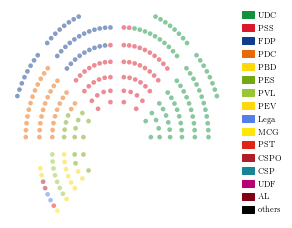

In [5]:
fig, ax = plt.subplots(1,1,figsize=(3.94, 3.94))

fig, ax = plotting.plot_graph(graph, party_colors, ax=ax, edges=False, colorbar=False)
ax = plotting.make_snc_legend(ax)

plt.savefig(os.path.join(save_path, 'snc_parties_no_edges.pdf'))
plt.show()

## Network of voting similarity

The second plot repeats the first, but adds to it edges, connecting councillors that had similar voting patterns throughout the 50th legislature. Each council member is connected to its 25 closest neighbors with respect to voting similarity.

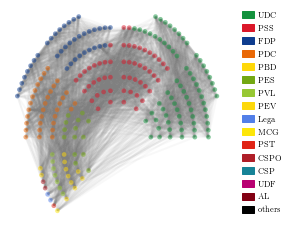

In [6]:
fig, ax = plt.subplots(1,1,figsize=(3.94, 3.94))

fig, ax = plotting.plot_graph(graph, party_colors, ax=ax, edges=True, colorbar=False)
ax = plotting.make_snc_legend(ax)

plt.savefig(os.path.join(save_path, 'snc_parties_with_edges.pdf'))
plt.show()

## Subsampled party colors

In the third plot, we subsample, uniformly at random, the party colors of half the members of the National Council. Visually, this means setting to an arbitrary color the dots corresponding to 50% of the councillors. Does the graph structure contain enough information to interpolate the missing colors?

In [7]:
smp_design = lambda g, m: smp.uniform_vertex(g, m, replace=True) # Uniform sampling design

m = int(0.5 * graph.n_vertices)

sampled_vertices = smp_design(graph, m)

sampled_party_colors = np.asarray(['#FFFFFF'] * len(party_colors)) # Set the color of unsampled dots to white
sampled_party_colors[sampled_vertices] = party_colors[sampled_vertices]

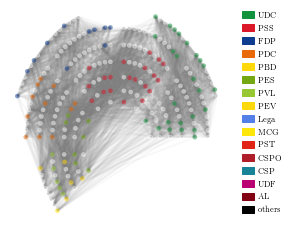

In [8]:
fig, ax = plt.subplots(1,1,figsize=(3.94, 3.94))

fig, ax = plotting.plot_graph(graph, sampled_party_colors, ax=ax, edges=True, colorbar=False)
ax = plotting.make_snc_legend(ax)

plt.savefig(os.path.join(save_path, 'snc_subsampled_parties_with_edges.pdf'))
plt.show()

## A numerical example 

To talk about recovery, we consider a numerical version of the party color problem. The cell below defines a graph signal as the indicator vector of [UDC](https://www.udc.ch/parti/), the largest party in the 50th legislature. The coordinates of this signal corresponding to members of UDC have a value of 1, whereas all the other coordinates have a value of 0.

In [9]:
parties = graph.info['parties']
parties_in_gt = ['UDC']
cls_mask = [False] * len(parties)
for p in parties_in_gt:
    cls_mask += (parties == p)

signal = np.sum(indicator_vectors[cls_mask,:], axis=0)

We set the recovery function to be the Graph Total-Variation (G-TV) decoder analysed in Chapter 5.

In [10]:
rtol = 1e-6 * (graph.n_vertices ** (-1/2))
maxit = 5000
verbosity = 'LOW'
rec_fun = lambda g, s_ver, s_val: rec.tv_interpolation(g, s_ver, s_val, rtol=rtol, maxit=maxit, verbosity=verbosity)

We sample half of the vertices, uniformly at random and attempt to recover the ground-truth indicator vector using the G-TV decoder.

In [11]:
# Subsample
sampled_vertices = smp_design(graph, m)
sampled_values = signal[sampled_vertices]
y = utils.nan_off_sample(graph.n_vertices, sampled_vertices, sampled_values)

# Recover
recovered_signal = rec_fun(graph, sampled_vertices, sampled_values)

Solution found after 797 iterations:
    objective function f(sol) = 1.471014e+02
    stopping criterion: RTOL


The final plot is a side-by-side visualization of the process: ground-truth, sampled, and recovered signals. Notice that the recovery is not perfect.

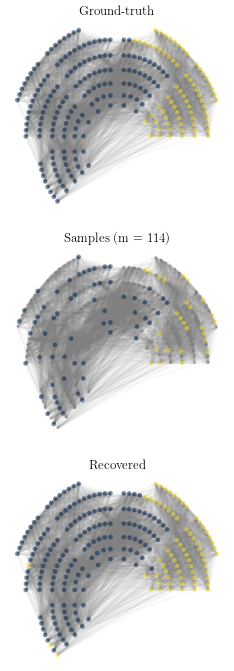

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(3.94, 11.82))
#fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3.94, 1.31))

limits = [min(signal), max(signal)]

plotting.plot_graph(graph, 
                    signal, 
                    ax=ax[0], 
                    limits=limits, 
                    edges=True, 
                    colorbar=False)

plotting.plot_graph(graph, 
                    y, 
                    ax=ax[1], 
                    limits=limits, 
                    edges=True, 
                    colorbar=False)

plotting.plot_graph(graph, 
                    recovered_signal, 
                    ax=ax[2], 
                    limits=limits, 
                    edges=True, 
                    colorbar=False)

ax[0].set(title=r'Ground-truth')
ax[1].set(title='Samples (m = {0})'.format(m))
ax[2].set(title='Recovered')

plt.savefig(os.path.join(save_path, 'snc_sample_rec_example.pdf'))
plt.show()